# ЧАЙНЫЙ ПРОЕКТ

Оценить, есть ли влияние от рекламы чая «Ахмад» в передаче «Что? Где? Когда?» на его продажи.

lipton — 29;
ahmad — 178; 
may — 5152.

## Критерии:
* 2 балла

Произведён парсинг данных о датах проведения передачи «Что? Где? Когда?»
* 4 балла

Построена модель, предсказывающая значение временного ряда продаж. Показано, что нет положительного misprediction.
* 2 балла

Построен boxplot, указано, что нет аномалии роста продаж после передачи.
* 2 балла

Сделана попытка кластеризации точек продаж (по всем трём вендорам).

In [1]:
import pandas as pd
import numpy as np
from scipy import stats
from fbprophet import Prophet
from sklearn.cluster import DBSCAN

from matplotlib.cbook import boxplot_stats  

RANDOM_SEED = 42
np.random.seed(RANDOM_SEED)

from google.colab import drive
drive.mount('/content/drive', force_remount=True)
DIR_DATA = './drive/MyDrive/Stud/SkillFactory/case_tea/'

Mounted at /content/drive


In [2]:
data = pd.read_csv(DIR_DATA+'tea_demand.csv', sep='\t')
data['date'] = pd.to_datetime(data['date'])

# show is on sunday (dayofweek=6), after that comes monday (dayofweek=0)
# shows was on 28.10.16, 04.11.2016, 11.11.2016, 18.11.2016, 26.11.2016
# http://www.gametv.az/ru/allnews/report/page/19.html

In [3]:
data.head()

,brand_id,date,receipts_count
0,5152,2016-07-01,98
1,178,2016-07-01,234
2,29,2016-07-01,622
3,5152,2016-07-02,87
4,178,2016-07-02,185


In [4]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 459 entries, 0 to 458
Data columns (total 3 columns):
 #   Column          Non-Null Count  Dtype         
---  ------          --------------  -----         
 0   brand_id        459 non-null    int64         
 1   date            459 non-null    datetime64[ns]
 2   receipts_count  459 non-null    int64         
dtypes: datetime64[ns](1), int64(2)
memory usage: 10.9 KB


In [5]:
# lipton — 29; ahmad — 178; may — 5152
lipton = data[data.brand_id == 29]
ahmad = data[data.brand_id == 178]
may = data[data.brand_id == 5152]


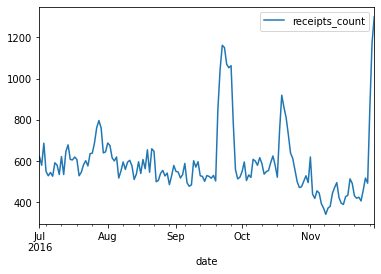

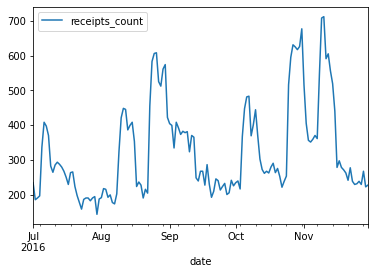

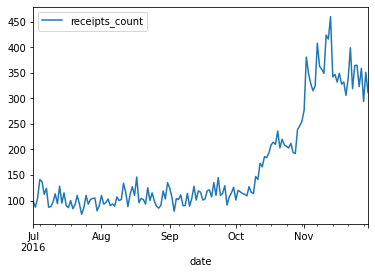

In [6]:
lipton.plot(x='date', y='receipts_count')
ahmad.plot(x='date', y='receipts_count')
may.plot(x='date', y='receipts_count')

In [7]:
# add rolling mean and std (7 days)
lipton['mean_7'] = lipton['receipts_count'].rolling(7).mean()
ahmad['mean_7'] = ahmad['receipts_count'].rolling(7).mean()
may['mean_7'] = may['receipts_count'].rolling(7).mean()

lipton['std_7'] = lipton['receipts_count'].rolling(7).std()
ahmad['std_7'] = ahmad['receipts_count'].rolling(7).std()
may['std_7'] = may['receipts_count'].rolling(7).std()

lipton.dropna(axis=0, inplace=True)
ahmad.dropna(axis=0, inplace=True)
may.dropna(axis=0, inplace=True)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

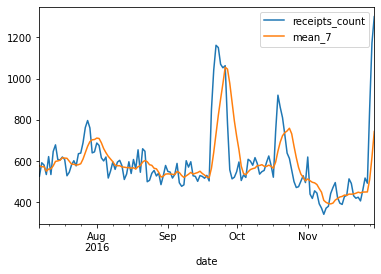

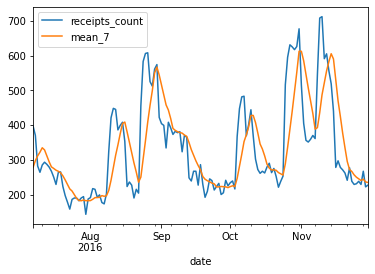

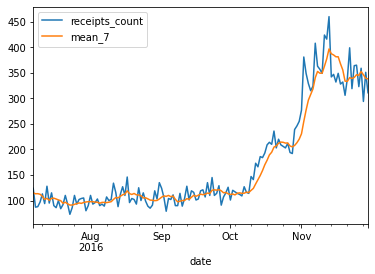

In [8]:
lipton.plot(x='date', y=['receipts_count', 'mean_7'])
ahmad.plot(x='date', y=['receipts_count', 'mean_7'])
may.plot(x='date', y=['receipts_count', 'mean_7'])


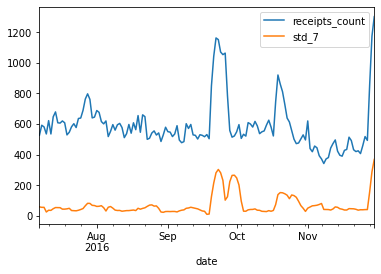

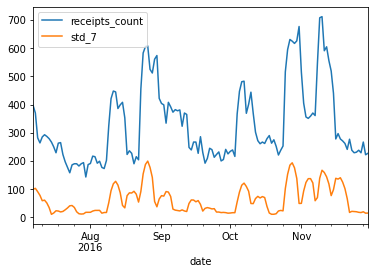

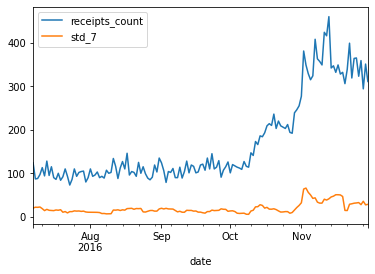

In [9]:
lipton.plot(x='date', y=['receipts_count', 'std_7'])
ahmad.plot(x='date', y=['receipts_count', 'std_7'])
may.plot(x='date', y=['receipts_count', 'std_7'])


In [10]:
# add difference between daily sales and weekly average
lipton['diff'] = lipton['receipts_count'] / lipton['mean_7']
ahmad['diff'] = ahmad['receipts_count'] / ahmad['mean_7']
may['diff'] = may['receipts_count'] / may['mean_7']


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

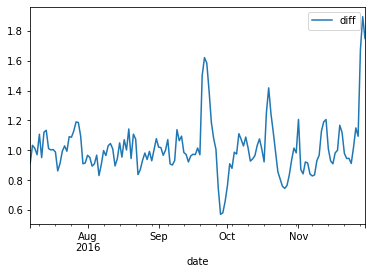

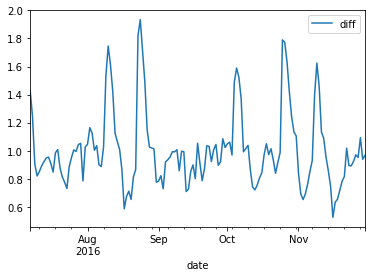

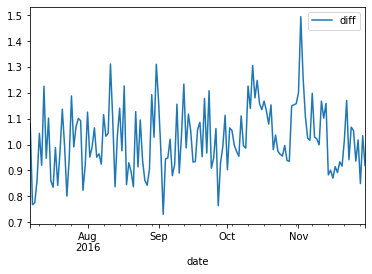

In [11]:
lipton.plot(x='date', y=['diff'])
ahmad.plot(x='date', y=['diff'])
may.plot(x='date', y=['diff'])


In [12]:
# train-test-split
lipton_tr, lipton_ts = lipton[lipton.date <= '2016-10-28'], lipton[lipton.date > '2016-10-28']
ahmad_tr, ahmad_ts = ahmad[ahmad.date <= '2016-10-28'], ahmad[ahmad.date > '2016-10-28']
may_tr, may_ts = may[may.date <= '2016-10-28'], may[may.date > '2016-10-28']

In [13]:
# H(0): продажи чая Ахмад не изменились после рекламы в шоу
print(stats.ttest_ind(lipton_tr.receipts_count, lipton_ts.receipts_count))
print(stats.ttest_ind(ahmad_tr.receipts_count, ahmad_ts.receipts_count))
print(stats.ttest_ind(may_tr.receipts_count, may_ts.receipts_count))

Ttest_indResult(statistic=3.4956019081300544, pvalue=0.0006278717597659365)
Ttest_indResult(statistic=-3.3337036331538563, pvalue=0.0010879137733186346)
Ttest_indResult(statistic=-27.816977709478042, pvalue=5.289938590757757e-60)


In [14]:
# H(0): скользящая средняя продаж чая Ахмад не отличается от других брендов
# после рекламы в шоу
print(stats.ttest_ind(ahmad_ts['diff'], lipton_ts['diff']))
print(stats.ttest_ind(ahmad_ts['diff'], may_ts['diff']))
print(stats.ttest_ind(lipton_ts['diff'], may_ts['diff']))

Ttest_indResult(statistic=-2.0438998308383796, pvalue=0.045083401266553545)
Ttest_indResult(statistic=-2.234368399082081, pvalue=0.028958522011689775)
Ttest_indResult(statistic=0.32057050173261015, pvalue=0.749580269584937)


In [15]:
# # H(0): скольщязее std не изменилось после рекламы одного бренда в шоу
print(stats.ttest_ind(ahmad_ts.std_7, lipton_ts.std_7))
print(stats.ttest_ind(ahmad_ts.std_7, may_ts.std_7))
print(stats.ttest_ind(lipton_ts.std_7, may_ts.std_7))

Ttest_indResult(statistic=1.214811889038856, pvalue=0.22890085848493702)
Ttest_indResult(statistic=5.316193727733641, pvalue=1.436399195364689e-06)
Ttest_indResult(statistic=2.589681979105148, pvalue=0.011880450999724432)


In [16]:
# построим прогнозы продаж на ноябрь
# гипотеза: точность модели для чая Ахмад будет ниже
# из-за влияния рекламной кампании, которую "не видит" модель

dfs = [lipton_tr, ahmad_tr, may_tr]

def makeforecast(df):
    transactions = df[["date", "receipts_count"]]
    transactions.columns = ['ds', 'y']

    m = Prophet()
    m.fit(transactions)
    future = m.make_future_dataframe(periods=30)
    forecast = m.predict(future)
    forecast.shape
    print('RMSE: %f' % np.sqrt(np.mean((forecast.loc[:144, 'yhat']-transactions['y'])**2)))

for df in dfs:
    makeforecast(df)

INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


RMSE: 69.041546


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


RMSE: 113.648583
RMSE: 78.683772


[677, 708, 712]


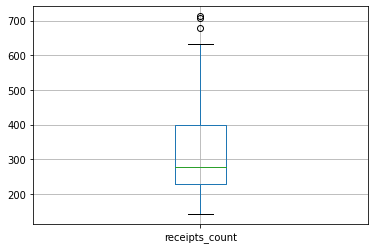

In [17]:
# Поиск аномалий с помощью BoxPlot и IQR
boxplot = ahmad.boxplot(column=['receipts_count'])  

boxplot_stats(ahmad.receipts_count).pop(0)['fliers']
outliers = [y for stat in boxplot_stats(ahmad['receipts_count']) for y in stat['fliers']]
print(outliers)

In [18]:
# Посмотрим на выбросы
ahmad.sort_values('receipts_count', ascending=False).head(3)

,brand_id,date,receipts_count,mean_7,std_7,diff
397,178,2016-11-10,712,486.714286,167.028655,1.462871
394,178,2016-11-09,708,435.857143,138.815739,1.624385
367,178,2016-10-31,677,612.428571,49.125204,1.105435


[797, 849, 1042, 1162, 1151, 1070, 1053, 1063, 920, 861, 811, 856, 1173, 1301]


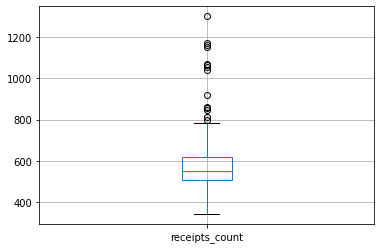

In [19]:
boxplot = lipton.boxplot(column=['receipts_count'])  

boxplot_stats(lipton.receipts_count).pop(0)['fliers']
outliers = [y for stat in boxplot_stats(lipton['receipts_count']) for y in stat['fliers']]
print(outliers)


In [20]:
# Посмотрим на выбросы
lipton.sort_values('receipts_count', ascending=False).head(14)

,brand_id,date,receipts_count,mean_7,std_7,diff
458,29,2016-11-30,1301,743.857143,368.715079,1.748992
455,29,2016-11-29,1173,618.714286,287.906648,1.895867
251,29,2016-09-22,1162,733.000000,281.581249,1.585266
254,29,2016-09-23,1151,822.285714,303.259907,1.399757
257,29,2016-09-24,1070,901.285714,281.743213,1.187193
263,29,2016-09-26,1063,1055.714286,102.923457,1.006901
260,29,2016-09-25,1053,975.857143,232.111632,1.079051
248,29,2016-09-21,1042,642.714286,214.412153,1.621249
332,29,2016-10-19,920,648.571429,139.100512,1.418502
335,29,2016-10-20,861,692.285714,152.253861,1.243706


[381, 408, 424, 416, 460, 399]


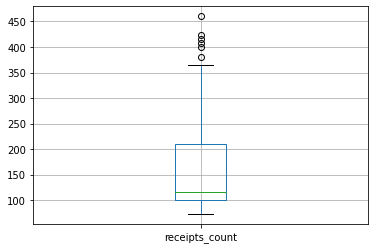

In [21]:
boxplot = may.boxplot(column=['receipts_count'])  

boxplot_stats(may.receipts_count).pop(0)['fliers']
outliers = [y for stat in boxplot_stats(may['receipts_count']) for y in stat['fliers']]
print(outliers)


In [22]:
# Посмотрим на выбросы
may.sort_values('receipts_count', ascending=False).head(6)

,brand_id,date,receipts_count,mean_7,std_7,diff
405,5152,2016-11-13,460,396.714286,41.310670,1.159525
399,5152,2016-11-11,424,362.857143,40.420410,1.168504
402,5152,2016-11-12,416,377.285714,38.469530,1.102613
387,5152,2016-11-07,408,340.428571,43.504242,1.198489
432,5152,2016-11-22,399,340.714286,28.831200,1.171069
372,5152,2016-11-02,381,254.857143,63.753245,1.494955


In [23]:
# Поищем аномалии, с помощью DBSCAN

dbscan = DBSCAN(eps=10, min_samples=3)
ahmad['dbscan'] = dbscan.fit_predict(ahmad['receipts_count'].values.reshape(-1, 1))

# Обнаруженные аномалии
ahmad[ahmad.dbscan < 0]

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.


,brand_id,date,receipts_count,mean_7,std_7,diff,dbscan
67,178,2016-07-23,158,216.142857,40.818413,0.730998,-1
88,178,2016-07-30,143,182.142857,17.667565,0.785098,-1
121,178,2016-08-10,421,241.142857,94.599909,1.745853,-1
184,178,2016-08-31,422,544.000000,65.061509,0.775735,-1
292,178,2016-10-06,481,315.571429,113.958848,1.524219,-1
295,178,2016-10-07,483,352.428571,121.270850,1.370490,-1
367,178,2016-10-31,677,612.428571,49.125204,1.105435,-1
394,178,2016-11-09,708,435.857143,138.815739,1.624385,-1
397,178,2016-11-10,712,486.714286,167.028655,1.462871,-1


In [24]:
# Поищем аномалии, с помощью DBSCAN

dbscan = DBSCAN(eps=10, min_samples=3)
lipton['dbscan'] = dbscan.fit_predict(lipton['receipts_count'].values.reshape(-1, 1))

# Обнаруженные аномалии
lipton[lipton.dbscan < 0]

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.


,brand_id,date,receipts_count,mean_7,std_7,diff,dbscan
80,29,2016-07-27,763,641.142857,66.225445,1.190062,-1
83,29,2016-07-28,797,671.857143,82.163310,1.186264,-1
86,29,2016-07-29,761,694.571429,81.608531,1.095640,-1
248,29,2016-09-21,1042,642.714286,214.412153,1.621249,-1
251,29,2016-09-22,1162,733.000000,281.581249,1.585266,-1
254,29,2016-09-23,1151,822.285714,303.259907,1.399757,-1
266,29,2016-09-27,784,1046.428571,125.202312,0.749215,-1
329,29,2016-10-18,745,595.571429,73.792179,1.250899,-1
332,29,2016-10-19,920,648.571429,139.100512,1.418502,-1
338,29,2016-10-21,811,723.428571,150.849657,1.121051,-1


In [25]:
# Поищем аномалии, с помощью DBSCAN

dbscan = DBSCAN(eps=10, min_samples=3)
may['dbscan'] = dbscan.fit_predict(may['receipts_count'].values.reshape(-1, 1))

# Обнаруженные аномалии
may[may.dbscan < 0]

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.


,brand_id,date,receipts_count,mean_7,std_7,diff,dbscan
309,5152,2016-10-12,173,132.428571,22.802464,1.306365,-1
312,5152,2016-10-13,166,140.571429,23.215348,1.180894,-1
369,5152,2016-11-01,277,230.714286,32.226874,1.200619,-1
372,5152,2016-11-02,381,254.857143,63.753245,1.494955,-1
405,5152,2016-11-13,460,396.714286,41.310670,1.159525,-1
450,5152,2016-11-28,294,346.142857,35.648415,0.849360,-1


## Выводы

* точность timeseries-прогноза Prophet ниже для чая Ахмад (т.к. модель "не видит" такого фактора, как наличие рекламы в шоу
* boxplot-анализ показал выбросы по всем трем маркам в ноябре
* DBSCAN показывает выбросами значения в ноябре для всех трех марок